In [1]:
import shapely
import math
import pyproj
import sys
import fiona
sys.path.append('../../../alg')

import matplotlib.pyplot as plt, pandas as pd, geopandas as gpd, numpy as np, osmnx as ox
import distance_buffer as db, border_generators as bg, marching_army as ma

from matplotlib import pyplot
from functools import partial
from shapely import geometry
from shapely.ops import transform
from descartes import PolygonPatch
from matplotlib.patches import Arc
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
%matplotlib inline

In [2]:
from scipy.stats import truncnorm

In [3]:
reload(db)

<module 'distance_buffer' from '../../../alg/distance_buffer.pyc'>

In [4]:
reload(ma)

<module 'marching_army' from '../../../alg/marching_army.pyc'>

In [5]:
reload(bg)

<module 'border_generators' from '../../../alg/border_generators.pyc'>

# Get place and show it

In [6]:
proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),pyproj.Proj(init='epsg:3857'))

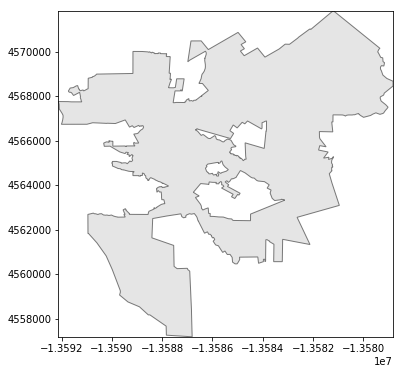

In [7]:
gdf, placegeom = bg.getplace('Walnut Creek, California, USA')
# plot the city
transgeom = transform(proj, placegeom)
west, south, east, north = transgeom.bounds
bounds = [west, south, east, north]
fig, ax = plt.subplots(figsize=(6,6))
for polygon in transgeom:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

# Create spatial index

In [8]:
sindex = gdf.sindex

### let's randomly generate pts w/ a normal distribution and test the rtree

In [9]:
# code in this block is from:
# https://stackoverflow.com/questions/36894191/how-to-get-a-normal-distribution-within-a-range-in-numpy

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [10]:
X_x = get_truncated_normal((-13582000.0), 1000, bounds[0], bounds[2])
X_y = get_truncated_normal((4568000.0),1000,bounds[1],bounds[3])

In [11]:
tempx = X_x.rvs(1000)
tempy = X_y.rvs(1000)

In [12]:
random_pts = gpd.GeoDataFrame(data={'x':tempx, 'y':tempy})

In [13]:
random_pts['geometry'] = random_pts.apply(lambda row: Point((row['x'], row['y'])), axis=1)

In [14]:
pts_sindex = random_pts.sindex

In [15]:
%%time
possible_matches_index = list(pts_sindex.intersection(bounds))
possible_matches = random_pts.iloc[possible_matches_index]
precise_matches = possible_matches[possible_matches.intersects(transgeom)]
points_within_geometry = precise_matches
points_outside_geometry = random_pts[~random_pts.isin(points_within_geometry)]





CPU times: user 764 ms, sys: 6.45 ms, total: 770 ms
Wall time: 782 ms


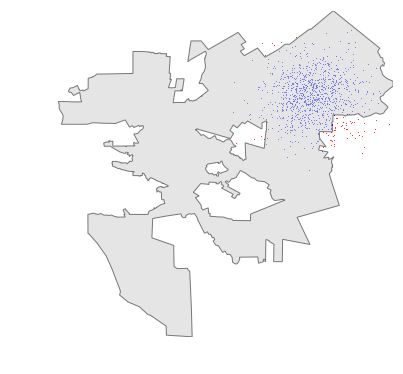

In [16]:
# plot the cut-up city
fig, ax = plt.subplots(figsize=(6,6))
for polygon in transgeom:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=3)
    ax.add_patch(patch)

ax.scatter(x=points_outside_geometry['x'], y=points_outside_geometry['y'], s=1, c='r', linewidth=0, zorder=1)
ax.scatter(x=points_within_geometry['x'], y=points_within_geometry['y'], s=1, c='b', linewidth=0, zorder=2)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
#plt.savefig("rtree-test1.png",  dpi=192 * 10)
plt.show()


In [17]:
optdist = 100*math.sqrt(3)
bounds = [bds[0]-100.0, bds[1]-100.0, bds[2]+100.0,bds[3]+100.0]

NameError: name 'bds' is not defined

In [18]:
bounds = wc_census10.bounds

NameError: name 'wc_census10' is not defined

In [19]:
bounds

[-13592126.456990628,
 4557195.678592932,
 -13578819.013366627,
 4571847.8160177665]

In [20]:
#  find diag point of geom's bounding box
diagdist = db.eucdist(tbounds[0],tbounds[1],tbounds[2],tbounds[3])[0]

NameError: name 'tbounds' is not defined

In [21]:
diagdist

NameError: name 'diagdist' is not defined

In [22]:
x_int = int(math.ceil((abs(bounds[0]-bounds[2]))/optdist))
y_int = int(math.ceil((abs(bounds[1]-bounds[3]))/optdist))

stopx = bounds[0]+(x_int*optdist)
stopy = bounds[2]+(y_int*optdist)

In [23]:
xs = np.linspace(west,stopx,x_int)
ys = np.linspace(south,stopy,y_int)

In [24]:
x_grid,y_grid = np.meshgrid(xs, ys)

In [25]:
x_grid

array([[-13592126.45699063, -13591950.97289565, -13591775.48880067, ...,
        -13579140.6339623 , -13578965.14986732, -13578789.66577235],
       [-13592126.45699063, -13591950.97289565, -13591775.48880067, ...,
        -13579140.6339623 , -13578965.14986732, -13578789.66577235],
       [-13592126.45699063, -13591950.97289565, -13591775.48880067, ...,
        -13579140.6339623 , -13578965.14986732, -13578789.66577235],
       ...,
       [-13592126.45699063, -13591950.97289565, -13591775.48880067, ...,
        -13579140.6339623 , -13578965.14986732, -13578789.66577235],
       [-13592126.45699063, -13591950.97289565, -13591775.48880067, ...,
        -13579140.6339623 , -13578965.14986732, -13578789.66577235],
       [-13592126.45699063, -13591950.97289565, -13591775.48880067, ...,
        -13579140.6339623 , -13578965.14986732, -13578789.66577235]])

In [26]:
gridtzip = np.array(zip(x_grid,y_grid))

In [27]:
gridtzip.shape

(85, 2, 77)

In [28]:
gridgpd = gpd.GeoDataFrame(data={'x':gridtzip[0,:,:].flatten(), 'y':gridtzip[1,:,:].flatten()})

In [29]:
t = gridtzip[0,:,:].flatten()

In [30]:
print len(t)
print len(xs)*len(ys)

154
6545


In [31]:
gridgpd['geometry'] = gridgpd.apply(lambda row: Point((row['x'], row['y'])), axis=1)
        

In [32]:
grid_index = gridgpd.sindex

In [33]:
%%time
possible_matches_index = list(grid_index.intersection(bounds))
possible_matches = gridgpd.iloc[possible_matches_index]
precise_matches = possible_matches[possible_matches.intersects(wc_census10)]
points_within_geometry = precise_matches
points_outside_geometry = gridgpd[~gridgpd.isin(points_within_geometry)]




NameError: name 'wc_census10' is not defined

NameError: name 'multi_wc_census10' is not defined

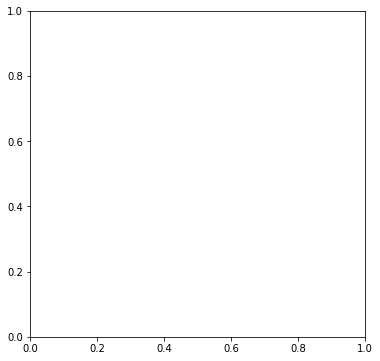

In [34]:
# plot the cut-up city
fig, ax = plt.subplots(figsize=(6,6))
for polygon in multi_wc_census10:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=3)
    ax.add_patch(patch)

ax.scatter(x=points_outside_geometry['x'], y=points_outside_geometry['y'], s=1, c='r', linewidth=0, zorder=1)
ax.scatter(x=points_within_geometry['x'], y=points_within_geometry['y'], s=1, c='b', linewidth=0, zorder=2)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
#plt.savefig("rtree-testgrid2.png",  dpi=192 * 10)
plt.show()


In [ ]:
len(points_within_geometry)

# New procedure:
- get a line
- get a starting point on the line (*OR:* get a starting point then get a direction vector?)
- gen array of x's, y's, then zip them
- gen a spatial index from pts
- intersect poly sindex with cand pt sindex



In [ ]:
def gen_grid_pts(bds, starpt, rot_dir):
    #min x, min y, max x, max y
    
    cur = starpt

# Let's generate random points based on real data from the 2010 census
- We can obtain GIS projects/shapefiles containing the block groups upon which data is collected in the census. source: https://www.census.gov/geo/maps-data/data/tiger-line.html
- We can obtain data on matching the geographies/BG's to their codes from http://proximityone.com/bg-zip.htm . I was unable to easily synthesize this data from the Census website itself. note that it is important to be sure you are using 2010 census BG's / codes because the American Community Survey (ACS) has their own, and an ACS is done every year
- Another resource with a good interactive/searchable map is https://www.policymap.com/maps ; you can search place, block group, tract, etc.

### How we will do it
1. get the geometries of the BG's from census data
2. overlap the geometries from the area you are interested in (this case, Walnut Creek, CA) to find out what BG's are in the region exactly; make sure you use the geom. version BEFORE translation 
3. generate n random points within each BG, and distribute the population P listed in that block from the data amongst the generated points
4. how to deal with semi-overlapping bg's -- decide later

In [35]:
county = fiona.open("../../../data/CA_WalnutCreek/CTY_ContaCostra/county_013.shp")

In [36]:
county.crs

{'init': u'epsg:4269'}

In [37]:
print county.schema

{'geometry': 'Polygon', 'properties': OrderedDict([(u'STATEFP10', 'str:2'), (u'COUNTYFP10', 'str:3'), (u'TRACTCE10', 'str:6'), (u'BLOCKCE', 'str:4'), (u'BLOCKID10', 'str:15'), (u'PARTFLG', 'str:1'), (u'HOUSING10', 'int:9'), (u'POP10', 'int:9')])}


In [38]:
county_iter = iter(county)

In [39]:
county_first = next(county_iter)
#county_sec = next(county_iter)

In [40]:
try_geom = shapely.geometry.shape(county_first['geometry'])


In [41]:
type(county_iter)

fiona.ogrext.Iterator

In [42]:
print len(county_first)
print type(county_first)

4
<type 'dict'>


In [43]:
poly_list = []
for polydict in county:
    poly_list.append(shapely.geometry.shape(polydict['geometry']))
    

In [44]:
type(poly_list[0])

shapely.geometry.polygon.Polygon

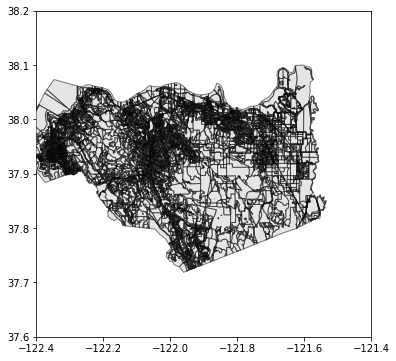

In [45]:
ig1, ax1 = plt.subplots(figsize=(6,6))
#west, south, east, north = 
for polygon in poly_list:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=3)
    ax1.add_patch(patch)
    
ax1.set_xlim(-122.4, -121.4)
ax1.set_ylim(37.6, 38.2)
plt.show()

In [46]:
proj2 = partial(pyproj.transform, pyproj.Proj(init='epsg:4269'),pyproj.Proj(init='epsg:3857'))

In [47]:
transpoly_list = []
for poly in poly_list:
    transpoly_list.append(transform(proj2, poly))


In [48]:
tbds = transpoly_list[0].bounds

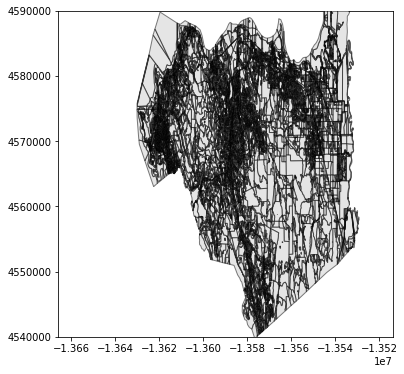

In [49]:
ig2, ax2 = plt.subplots(figsize=(6,6))
transpatches = []
#west, south, east, north = 
for polygon in transpoly_list:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=3)
    transpatches.append(patch)
    ax2.add_patch(patch)
    
ax2.set_xlim(-13666000, tbds[2]+100000)
ax2.set_ylim(4540000, 4590000)
plt.show()

In [50]:
-13666000+50000

-13616000

In [51]:
transgeom.bounds

(-13592126.456990628,
 4557195.678592932,
 -13578819.013366627,
 4571847.8160177665)

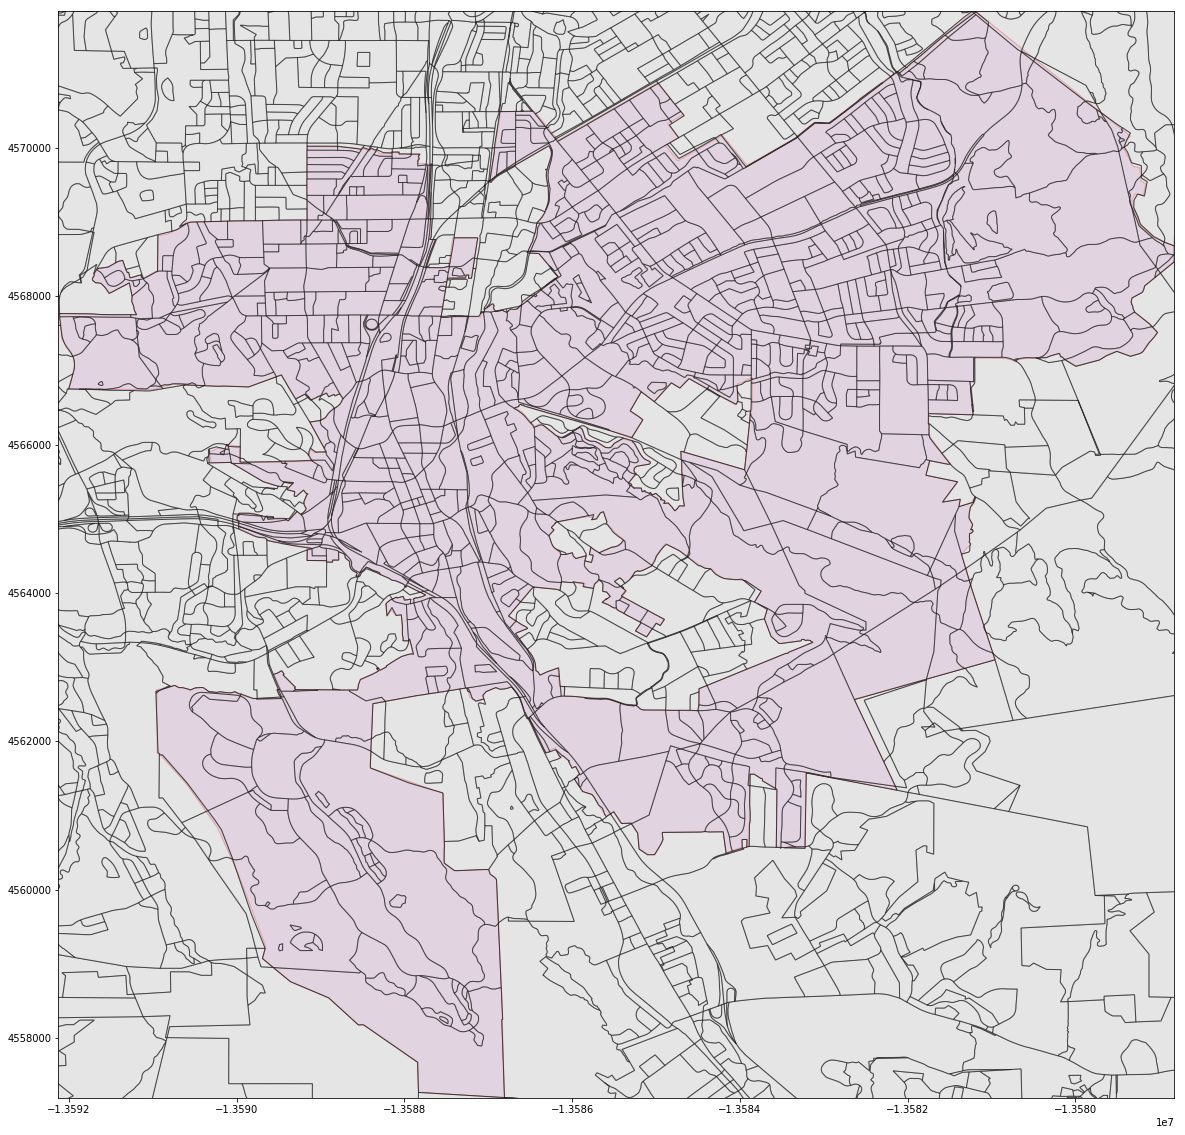

In [52]:
ig3, ax3 = plt.subplots(figsize=(20,20))
for polygon in transpoly_list:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax3.add_patch(patch)

for polygon in transgeom:
    patch = PolygonPatch(polygon, fc='#f2b9ed', ec='r', alpha=0.5, zorder=1)
    ax3.add_patch(patch)

        
ax3.set_xlim(west, east)
ax3.set_ylim(south, north)
plt.show()

In [53]:
bg_dataframes = []
x_bg = []
y_bg = []
for poly in transpoly_list:
    tempx_bg = []
    tempy_bg = []
    if type(poly) is Polygon:
        ring = poly.exterior.coords
    else:
        ring = poly[0].exterior.coords
    for i in range(0, len(ring)):
        tempx_bg.append(ring[i][0])
        tempy_bg.append(ring[i][1])
    x_bg.append(tempx_bg)
    y_bg.append(tempy_bg)
        
    
# TODO: fix this loop to handle diff types of polygons (multi, and exterior/interior)

In [54]:
bg_dataframes = []

for i in range(0, len(x_bg)):
    tempframe = gpd.GeoDataFrame(data={'x':x_bg[i], 'y':x_bg[i]})
    tempframe['geometry'] = tempframe.apply(lambda row: Point((row['x'], row['y'])), axis=1)
    bg_dataframes.append(tempframe)

In [55]:
len(bg_dataframes)

18309

In [56]:
# spatial index intersection for these polys
bg_sindex = []
for frame in bg_dataframes:
    bg_sindex.append(frame.sindex)

In [57]:
len(bg_sindex)

18309

In [58]:
338302

338302

In [59]:
tpoly_list = []
for polydict in county:
    if polydict['properties']['TRACTCE10'] == '338302':
        tpoly_list.append(shapely.geometry.shape(polydict['geometry']))

In [60]:
temp = []
for poly in tpoly_list:
    temp.append(transform(proj2, poly))
tpoly_list = temp

In [61]:
ingeom = []
outgeom = []
cnt = 0
tbounds = transgeom.bounds
for index in bg_sindex:
    tdataframe = bg_dataframes[cnt]
    cnt+=1
    tpossible_matches_index = list(index.intersection(tbounds))
    tpossible_matches = tdataframe.iloc[tpossible_matches_index]
    tprecise_matches = tpossible_matches[tpossible_matches.intersects(transgeom)]
    ingeom.append(tprecise_matches)
    if len(tprecise_matches) > 0:
        print ingeom
    tpoints_within_geometry = tprecise_matches
    outgeom.append(tdataframe[~tdataframe.isin(tpoints_within_geometry)])


In [ ]:
print len(ingeom)
print len(outgeom)

In [ ]:
maxlen = 0
theone = 0
for i in range(0, len(ingeom)):
    if len(ingeom[i]) > maxlen:
        maxlen = len(ingeom[i])
        theone = ingeom[i]
    #if len(outgeom[i])>maxlen:
    #    maxlen=len(outgeom[i])
    #    theone = outgeom[i]

In [ ]:
multitpoly = MultiPolygon(tpoly_list)

In [ ]:
# plot the cut-up city
fig4, ax4 = plt.subplots(figsize=(10,10))
for polygon in transgeom:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=1)
    ax4.add_patch(patch)

for p in multitpoly:
    #tpoly = Polygon([[p.x, p.y] for p in tpoly_list['geometry']])
    patch = PolygonPatch(p, fc='#f2b9ed', ec='k', alpha=0.5, zorder=2)
    ax4.add_patch(patch)
        

#west,south,east,north=multitpoly.bounds
west,south,east,north=transgeom.bounds

ax4.set_xlim(west, east)
ax4.set_ylim(south, north)
ax4.axis('off')
#plt.savefig("rtree-testgrid2.png",  dpi=192 * 10)
plt.show()

In [ ]:
print multitpoly.bounds
print transgeom.bounds

In [ ]:
for i in range(0, len(ingeom)):
    if len(ingeom[i])>0:
        tpoly = Polygon([[p.x, p.y] for p in ingeom[i]['geometry']])

        patch = PolygonPatch(tpoly, fc='#cccccc', ec='k', alpha=0.5, zorder=3)
        ax4.add_patch(patch)
        
        #ax4.scatter(x=ingeom[i]['x'], y=ingeom[i]['y'], s=1, c='r', linewidth=0, zorder=1)
    if len(outgeom[i])>0:
        tpoly = Polygon([[p.x, p.y] for p in outgeom[i]['geometry']])

        patch = PolygonPatch(tpoly, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
        ax4.add_patch(patch)
        #ax4.scatter(x=outgeom[i]['x'], y=outgeom[i]['y'], s=1, c='b', linewidth=0, zorder=2)


In [ ]:
# read in FACES file 
countyfaces = fiona.open("../../../data/CA_WalnutCreek/CTY_faces/tl_2010_06013_faces.shp")

In [ ]:
#countyfaces.schema

In [ ]:
# read in CA places (to get the place code)
ca_places = fiona.open("../../../data/CA_WalnutCreek/CA_places/tl_2010_06_place10.shp")

In [ ]:
ca_places.schema

In [ ]:
type(ca_places)

In [ ]:
def find_place(placename, fcollection):
    match = []
    for i in range(0, len(fcollection)):
        if fcollection[i]['properties']['NAME10'] == placename:
            match = fcollection[i]
    
    return match
    

In [ ]:
m = find_place("Walnut Creek", ca_places)

In [ ]:
m

In [ ]:
wc_census10 = shapely.geometry.shape(m['geometry'])

In [ ]:
wc_census10 = transform(proj2, wc_census10)

In [ ]:
wc_census10

In [ ]:
transgeom.bounds

In [ ]:
wc_census10.bounds

In [ ]:
m['properties']

In [ ]:
def match_place_to_faces(placefp10, faces_collec):
    matches = []
    for i in range(0, len(countyfaces)):
        if countyfaces[i]['properties']['PLACEFP10'] == placefp10:
            matches.append(countyfaces[i])
    
    return matches

In [ ]:
wc_matches = match_place_to_faces(m['properties']['PLACEFP10'], countyfaces)

In [ ]:
len(wc_matches)

In [ ]:
wc_blockgeoms = []
for i in range(0, len(wc_matches)):
    wc_blockgeoms.append(shapely.geometry.shape(wc_matches[i]['geometry']))

In [ ]:
len(wc_blockgeoms)

In [ ]:
multi_wc_blockgeoms = MultiPolygon(wc_blockgeoms)

In [ ]:

multi_wc_census10 = MultiPolygon([wc_census10])

In [ ]:
tmulti_wc_blockgeoms = []
for poly in multi_wc_blockgeoms:
    tmulti_wc_blockgeoms.append(transform(proj2, poly))

In [ ]:
len(tmulti_wc_blockgeoms)


In [ ]:
fig5, ax5 = plt.subplots(figsize=(10,10))
for polygon in multi_wc_census10:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=1)
    ax5.add_patch(patch)

for p in tmulti_wc_blockgeoms:
    #tpoly = Polygon([[p.x, p.y] for p in tpoly_list['geometry']])
    patch = PolygonPatch(p, fc='#f2b9ed', ec='k', alpha=0.5, zorder=2)
    ax5.add_patch(patch)
        

#west,south,east,north=multitpoly.bounds
west,south,east,north=wc_census10.bounds

ax5.set_xlim(west, east)
ax5.set_ylim(south, north)
ax5.axis('off')
plt.savefig("wc-all-blockgroups.png",  dpi=192 * 10)
plt.show()

In [ ]:
wc_matches[0]

## Now we'll read in the population info shapefile

BLOCKID10 format:

**Gsscccttttttbxxx**

- ss = state FIPS code (STATEFP10)

- ccc = county FIPS code (COUNTYFP10)
- tttttt = census tract code (TRACTCE10)
- b = census block group number (BLKGRPCE10)
- bxxx = census block tabulation number (BLOCKCE10)

Note: block assignment text files (BlockAssign_ST06_CA_INCPLACE_CDP.txt)

but, it only found 987 blocks in walnut creek....

In [ ]:
ca_pop_bg = fiona.open("../../../data/CA_WalnutCreek/CA_pop_bg/tabblock2010_06_pophu.shp")

In [ ]:
ca_pop_bg.schema


In [ ]:
#filter to contra costa county
cc_pop_bg = []
for i in range(0, len(ca_pop_bg)):
    if ca_pop_bg[i]['properties']['COUNTYFP10'] == '013':
        cc_pop_bg.append(ca_pop_bg[i])

In [ ]:
print cc_pop_bg[0]['properties']['BLOCKID10']
print [wc_matches[0]['properties']['STATEFP10'], wc_matches[0]['properties']['COUNTYFP10'], wc_matches[0]['properties']['TRACTCE10'], wc_matches[0]['properties']['BLKGRPCE10'], wc_matches[0]['properties']['BLOCKCE10']]
print str(wc_matches[0]['properties']['STATEFP10'])+ str(wc_matches[0]['properties']['COUNTYFP10'])+str(wc_matches[0]['properties']['TRACTCE10'])+str(wc_matches[0]['properties']['BLOCKCE10'])


       

In [ ]:
len(cc_pop_bg)

In [ ]:
len(ca_pop_bg)

In [ ]:
wc_pop_bg = []
for i in range(0,len(wc_matches)):
    matchstr = str(wc_matches[i]['properties']['STATEFP10'])+ str(wc_matches[i]['properties']['COUNTYFP10'])+str(wc_matches[i]['properties']['TRACTCE10'])+str(wc_matches[i]['properties']['BLOCKCE10'])
    for j in range(0, len(cc_pop_bg)):
        if cc_pop_bg[j]['properties']['BLOCKID10'] == matchstr:
            wc_pop_bg.append(cc_pop_bg[j])
        

In [ ]:
print len(wc_pop_bg)
print len(wc_matches)

In [ ]:
temp_wc_pop_bg = []
dups = []
listofids = []
for i in range(0, len(wc_pop_bg)):
    tid = str(wc_pop_bg[i]['properties']['BLOCKID10'])
    if tid not in listofids:
        listofids.append(tid)
        temp_wc_pop_bg.append(wc_pop_bg[i])
    else:
        dups.append(wc_pop_bg[i])
        

In [ ]:
# loop to make sure duplicates removed didnt have a differnet population
for i in range(0, len(dups)):
    thedup = str(dups[i]['properties']['BLOCKID10'])
    for j in range(0, len(temp_wc_pop_bg)):
        if thedup == str(temp_wc_pop_bg[j]['properties']['BLOCKID10']):
            p1 = dups[i]['properties']['POP10']
            p2 = temp_wc_pop_bg[j]['properties']['POP10']
            if not p1==p2:
                print p1
                print p2

In [ ]:
print len(temp_wc_pop_bg)
wc_pop_bg = temp_wc_pop_bg

In [ ]:
#print transform(proj2, shapely.geometry.shape(wc_pop_bg[0]['geometry']))

In [ ]:
#print multi_twc_pop_bg[0]

In [ ]:
#print twc_pop_bg[0]

In [ ]:
len(wc_pop_bg)

In [ ]:
twc_pop_bg = []
for l in wc_pop_bg:
    twc_pop_bg.append(transform(proj2, shapely.geometry.shape(l['geometry'])))

In [ ]:
print len(twc_pop_bg)
print type(twc_pop_bg[0])

In [ ]:
multi_twc_pop_bg = MultiPolygon(twc_pop_bg)

In [ ]:
fig6, ax6 = plt.subplots(figsize=(10,10))
for polygon in multi_wc_census10:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=1)
    ax6.add_patch(patch)

for i in range(0, len(multi_twc_pop_bg)):#p in multi_twc_pop_bg:
    #tpoly = Polygon([[p.x, p.y] for p in tpoly_list['geometry']])
    tpop = wc_pop_bg[i]['properties']['POP10']
    if tpop ==0: 
        tpop = 1
    patch = PolygonPatch(multi_twc_pop_bg[i], fc='#000000', ec='k', alpha=(tpop/(tpop+300.0)), zorder=2)
    ax6.add_patch(patch)
        

#west,south,east,north=multitpoly.bounds
west,south,east,north=multi_wc_census10.bounds

ax6.set_xlim(west, east)
ax6.set_ylim(south, north)
ax6.axis('off')
plt.savefig("images/population_blockgroups1.png",  dpi=192 * 10)
plt.show()

In [ ]:
max(listofpops)

# Now we will generate random points in a block and assign a population into that point

In [ ]:
def gen_n_random_coords(bds, n):
    xs = []
    ys = []
    for i in range(0,n):
        xs.append(ma.gen_rand_pt(bds[0], bds[2]))
        ys.append(ma.gen_rand_pt(bds[1],bds[3]))
    return xs, ys

In [ ]:
print len(wc_pop_bg)
print type(multi_twc_pop_bg[0])

In [ ]:
# gen 100 random pts (we only need 10)
randpts_inbgs = []

for i in range(0, len(wc_pop_bg)):
    pop = wc_pop_bg[i]['properties']['POP10']
    if not pop == 0:
        xs,ys = gen_n_random_coords(multi_twc_pop_bg[i].bounds, 100)
        random_pts = gpd.GeoDataFrame(data={'x':xs, 'y':ys})
        # now find ones that intercept with the region
        
        random_pts['geometry'] = random_pts.apply(lambda row: Point((row['x'], row['y'])), axis=1)
        pts_sindex = random_pts.sindex
        possible_matches_index = list(pts_sindex.intersection(bounds))
        possible_matches = random_pts.iloc[possible_matches_index]
        precise_matches = possible_matches[possible_matches.intersects(multi_twc_pop_bg[i])]
        #points_within_geometry = precise_matches
        #points_outside_geometry = random_pts[~random_pts.isin(points_within_geometry)]
        matches10 = precise_matches[0:10]
        randpts_inbgs.append(matches10)
        
        
        

In [ ]:
#generate points for the whole RoI
xs,ys = gen_n_random_coords([west,south,east,north], 5000)
random_pts_all = gpd.GeoDataFrame(data={'x':xs, 'y':ys})
    
random_pts_all['geometry'] = random_pts_all.apply(lambda row: Point((row['x'], row['y'])), axis=1)
all_pts_sindex = random_pts_all.sindex

#now find ones that intercept the region by BG

pts_per_bg = []
pops_per_bg= []


for i in range(0,len(multi_twc_pop_bg)):
    tgb_pop = wc_pop_bg[i]['properties']['POP10']
    pops_per_bg.append(tgb_pop)
    all_precise_matches = []
    if tgb_pop > 0: # only check for point intersections if the population >0
        poly = multi_twc_pop_bg[i]
        polybds = poly.bounds 
        
        all_possible_matches_index = list(all_pts_sindex.intersection(polybds))
        all_possible_matches = random_pts_all.iloc[all_possible_matches_index]
        all_precise_matches = all_possible_matches[all_possible_matches.intersects(poly)]
        
        while len(all_precise_matches)==0:
            #gen new random points focused on the BG at hand
            tx, ty = gen_n_random_coords(polybds, 10)
            trandom_pts = gpd.GeoDataFrame(data={'x':tx, 'y':ty})
            trandom_pts['geometry'] = trandom_pts.apply(lambda row: Point((row['x'], row['y'])), axis=1)
            trandom_pts_sindex = trandom_pts.sindex
            
            tpossible_matches_index = list(trandom_pts_sindex.intersection(polybds))
            tpossible_matches = trandom_pts.iloc[tpossible_matches_index]
            all_precise_matches = tpossible_matches[tpossible_matches.intersects(poly)]
            
        
        # make sure there's not more points than people in the bg
        if len(all_precise_matches) > tbg_pop:
            all_precise_matches = all_precise_matches[0:tbg_pop]
        
    pts_per_bg.append(all_precise_matches)
        

            
            #now check if they intersect w the bg
            
            
        
        #make sure there is >0 pt in each area with a non-0 population

In [ ]:
print len(pts_per_bg)
print len(pops_per_bg)

In [ ]:
# could split pop evenly or randomly amongst pop. pts
# pts_per_bg : list of x,y coords specifying randomly generated pts in the bg's
# pop_list : the population per the entire bg
def assign_pops_to_pts_old(pts_per_bg, pop_list):
    
    pops = []
    for i in range(0, len(pop_list)):
        tpop = pop_list[i]
        tpops = []
        # if there is a nonzero pop, distribute the pop amongst the generated random pts in the BG
        if tpop > 0:
            tpts = len(pts_per_bg[i])
            tmax = tpop
            for i in range(0, tpts-1):
                if tmax==1:
                    break
                t = np.random.randint(1,tmax)
                print t
                tpops.append(t)
                tmax = tmax-t
                print tmax
                
                
            tpops.append(tmax)
        pops.append(tpops)
        
    return pops
                


In [ ]:
# code from phd thesis http://jeromekelleher.net/generating-integer-partitions.html
def accel_asc(n):
    a = [0 for i in range(n + 1)]
    k = 1
    y = n - 1
    while k != 0:
        x = a[k - 1] + 1
        k -= 1
        while 2 * x <= y:
            a[k] = x
            y -= x
            k += 1
        l = k + 1
        while x <= y:
            a[k] = x
            a[l] = y
            yield a[:k + 2]
            x += 1
            y -= 1
        a[k] = x + y
        y = x + y - 1
        yield a[:k + 1]

In [ ]:
def assign_pops_to_pts(pts, pops):
    pops_per_pts = []
    
    for i in range(0, len(pts)):
        tpop = pops[i]
        numpts = len(pts[i])
        if tpop == 0:
            theone = []
        elif numpts == 1: # assign whole pop to one pt in the case that there's one pt in the BG
            theone = [tpop]
        else:
                
            tempgen = accel_asc(tpop)
            tpart = tempgen.next()
            tpartl = len(tpart)
            possparts = []
        
        # this loop will grab the first partition that has the same # of bins as there are pts in the BG.
        # the gen func creates ascending partitions, so it will be the lowest satisfiying partition
        #NOPE. wont work. will akways just get a bunch of ones. SO: get all the partitions of that length then pick one
            #print pops[i]
            #print numpts
            #print tpartl
            while tpartl >= numpts:
                #print numpts
                #print tpartl
                if tpartl == numpts:
                    #print "in here"
                    possparts.append(tpart)
                tpart = tempgen.next()
                tpartl = len(tpart)
                
        # pick index randomly from possible partitions
            #print len(possparts)
            theone = possparts[np.random.randint(0,len(possparts)-1)] 
        pops_per_pts.append(theone)
        
    return pops_per_pts      

In [ ]:
poptest = assign_pops_to_pts_old(pts_per_bg, pops_per_bg)

In [ ]:
len(poptest)

In [ ]:
poptest

In [ ]:
pts_per_bg[1:2]

In [ ]:
for i in range(0,len(pts_per_bg)):
    if len(pts_per_bg[i]) == 0:
        print wc_pop_bg[i]['properties']['POP10']

In [ ]:
multi_twc_pop_bg[0].bounds

In [ ]:
pts_per_bg[0]['x']

In [ ]:
fig7, ax7 = plt.subplots(figsize=(10,10))
for polygon in multi_wc_census10:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=1)
    ax7.add_patch(patch)

for i in range(0, len(multi_twc_pop_bg)):#p in multi_twc_pop_bg:
    #tpoly = Polygon([[p.x, p.y] for p in tpoly_list['geometry']])
    tpop = wc_pop_bg[i]['properties']['POP10']
    if tpop ==0: 
        tpop = 1
    patch = PolygonPatch(multi_twc_pop_bg[i], fc='#000000', ec='k', alpha=0.15, zorder=2) #tpop/(tpop+300.0)
    ax7.add_patch(patch)

for i in range(0, len(pts_per_bg)):
    if len(pts_per_bg[i])>0:
        ax7.scatter(x=pts_per_bg[i]['x'], y=pts_per_bg[i]['y'], s=1, c='r', linewidth=0, zorder=3)

        

#west,south,east,north=multitpoly.bounds
west,south,east,north=multi_wc_census10.bounds

ax7.set_xlim(west, east)
ax7.set_ylim(south, north)
ax7.axis('off')
plt.savefig("images/population_blockgroups_pts_whole.png",  dpi=192 * 10)
plt.show()

In [ ]:
pts_per_bg[0]

In [ ]:
# take each grid point and see what it covers
# pick the best ones based on how many facilities you want to locate

def best_facilities(poppts_gdf, candpts_gdf, optdist):
    
    
    facility_cover_scores = []
    
    for i in range(0, len(candpts_gdf)):
        
        tpts_covered = []
        for j in range(0, len(poppts)):
            for k in range(0, len(poppts[j])):
               
                # check distance to cand pt , if less than r, it's covered - add to covered list and pop cover ticker
                
    
    
    # based on how many facilities u specified, pick the ones that cover the highest population


        
        

In [ ]:
def assign_pops_to_pts(pts_per_bg, pops_per_bg):
    pop_partitions = []
    
    for i in range(0, len(pts_per_bg)):
        bgpop = pops_per_bg[i]
        bgpts = pts_per_bg[i]
        numpts = len(bgpts)
        pop_remains = bgpop
        pt_remains = bgpts
        
        partition = []
        partition_not_found = True
        # only partition pts if nonzero pop
        if bgpop == 0:
            print "0 pop"
            pop_partitions.append(partition)
            partition_not_found = False
        elif bgpop == numpts: # simple partition each pt gets 1
            partition = [1]*numpts
            pop_partitions.append(partition)
            partition_not_found = False
        elif bgpop > numparts: # too many pts for the total pop, shave off some pts and assign 1's
            pops_per_bg[i] = pops_per_bg[i][0:bgpop]
            partition = [1]*bgpop
            pop_partitions.append(partition)
            partition_not_found = False
            
            # non simple partition case; now find the partition
            while partition_not_found: # loop until we find the partition
                if pop_remains == pt_remains:
                    # if the # pts left ever =='s the # pop left, 
                    # just assign 1's to the rest of the pts
                    partition.extend(([1]*pop_remains))
                    pop_partitions.append(partition)
                    partition_not_found = False
                    continue
                if pt_remains == 1:
                    partition.append(pop_remains)
                    pop_partitions.append(partition)
                    partition_not_found = False
                    continue
                    
                randnum = np.random.randint(1,pop_remains)
                partition.append(randnum)
                # decrease remaining pts and pops accordingly
                pop_remains = pop_remains-randnum
                pt_remains -= 1
    
    return pop_partitions

                    
                    
                
    